In [15]:
'''
Simulation of between-subjects regressor effects on HDDM parameters

The goal of the script is to verify that effects of between-subjects regressor on 
HDDM parameters can be accurately estimated, including when there are also within-subject effects.

Values of a between-subject regressor on a or v are simulated by creating multiple subject datasets at increasing
values of the regressor.  

Created on Feb 8, 2017
'''

import hddm
from numpy import mean, std
import numpy as np         
from pandas import Series
import pandas as pd
import os as os
import matplotlib.pyplot as plt

os.chdir('/Users/corrado/_repositories/eating_disorders_montecatini/scripts/python/PRL/classification/storage')

In [16]:
## Generate data

beta_a = 0.4  # between subjects scaling factor - adjust this and should be able to recover its true value
a_int = 1  # set intercept within range of empirical priors 
v_int = 0.3
x_range = range(11)  # set values of between subject measures, here from 0 to 10
trials_per_level = 200    
subjs_per_bin = 10

data_group = pd.DataFrame()  # empty df to append to  

for x in x_range:
    xx = (x - mean(x_range)) / std(x_range)  # z-score the x factor
    a = a_int + beta_a * xx  #  indiv subj param values that are centered on intercept but deviate from it up or down by z-scored x
    # v = v_int+ beta_a*xx  # can also do for drift, here using same beta coeff
    
    # parvec = {'v':.3, 'a':a, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
    # parvec2 = {'v':.3, 'a':a+.5, 't':.3, 'sv':0, 'z':.5, 'sz':0, 'st':0}
    parvec = {'v':.3, 'a':a, 't':.3}  # set a to value set by regression, here v is set to constant

    # note that for subjs_per_bin > 1, these are just the mean values of the parameters; indiv subjs within bin are sampled from distributions with the given means, but can still differ within bin around those means. 
    #not including sv, sz, st in the statement ensures those are actually 0.

    data_a, params_a = hddm.generate.gen_rand_data({'level1': parvec}, size=trials_per_level, subjs=subjs_per_bin)
    
    # can also do with two levels of within-subj conditions
    # data_a, params_a = hddm.generate.gen_rand_data({'level1': parvec,'level2': parvec2}, size=trials_per_level, subjs=subjs_per_bin)

    data_a['z_x'] = Series(xx * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['x'] = Series(x * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['a_population'] = Series(a * np.ones((len(data_a))), index=data_a.index)  # store the (z-scored) between subjects factor in the data frame, same value for every row for each subject in the bin
    data_a['subj_idx'] = Series(x * subjs_per_bin + data_a['subj_idx'] * np.ones((len(data_a))), index=data_a.index)  # store the correct subj_idx when iterating over multiple subjs per bin
     
    # concatenate data_a with group data
    data_a_df = pd.DataFrame(data=[data_a])
    data_group = data_group.append([data_a], ignore_index=True)

#write original simulated data to file
data_group.to_csv('data_group.csv')

In [22]:
data_group.head()

,Unnamed: 0,rt,response,subj_idx,condition,z_x,x,a_population
0,0,0.458446,0.0,0.0,level1,-1.581139,0.0,0.367544
1,1,0.477446,1.0,0.0,level1,-1.581139,0.0,0.367544
2,2,0.458446,0.0,0.0,level1,-1.581139,0.0,0.367544
3,3,0.450446,0.0,0.0,level1,-1.581139,0.0,0.367544
4,4,0.451446,0.0,0.0,level1,-1.581139,0.0,0.367544


In [24]:
data_group.groupby(['subj_idx']).agg({'x': 'mean'})

,x
subj_idx,
0.0,0.0
1.0,0.0
2.0,0.0
3.0,0.0
4.0,0.0
...,...
105.0,10.0
106.0,10.0
107.0,10.0


In [31]:
print(data_group['x'].unique())

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [34]:
print(data_group['subj_idx'].unique())

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.]


In [17]:
## Recover parameters
a_reg = {'model': 'a ~ 1 + z_x', 'link_func': lambda x: x}
# a_reg_within = {'model': 'a ~ 1+x + C(condition)', 'link_func': lambda x: x}
# for including and estimating within subject effects of  condition

v_reg = {'model': 'v ~ 1 + z_x', 'link_func': lambda x: x}
reg_comb = [a_reg, v_reg]
# m_reg = hddm.HDDMRegressor(data_group, reg_comb, group_only_regressors=['true']) 

m_reg = hddm.HDDMRegressor(data_group, a_reg, group_only_regressors=['true'])
m_reg.find_starting_values()
m_reg.sample(30, burn=5, dbname='a_bwsubs_t200.db', db='pickle')
m_reg.save('a_bwsubs_model_t200')

Adding these covariates:
['a_Intercept', 'a_z_x']


/opt/anaconda3/envs/hddmpy36/lib/python3.6/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------103%------------------] 31 of 30 complete in 53.3 secWARNING: Will not save custom link functions.


In [18]:
m_reg.print_stats()  # check values of reg coefficients against the generated ones

                            mean       std      2.5q       25q       50q       75q     97.5q    mc err
v                       0.288003  0.019992  0.248918  0.279621  0.293722  0.302898  0.312070  0.003998
v_std                   0.114129  0.027433  0.088226  0.097266  0.107896  0.117963  0.197616  0.005487
v_subj.0.0              0.312042  0.103633  0.051696  0.269774  0.317726  0.377599  0.570794  0.020727
v_subj.1.0              0.260538  0.113713  0.111374  0.179625  0.234881  0.361504  0.467191  0.022743
v_subj.2.0              0.300165  0.090325  0.087935  0.238270  0.304536  0.358502  0.462126  0.018065
v_subj.3.0              0.265024  0.142051 -0.091664  0.184316  0.300653  0.356867  0.491386  0.028410
v_subj.4.0              0.263906  0.116525  0.041316  0.159329  0.285679  0.356930  0.449671  0.023305
v_subj.5.0              0.291312  0.086766  0.117388  0.236617  0.274488  0.347626  0.458384  0.017353
v_subj.6.0              0.262671  0.149393 -0.180971  0.218407  0.287287 

Pearson correlation between a_x and x
(0.9666733470304139, 9.793973935865627e-66)


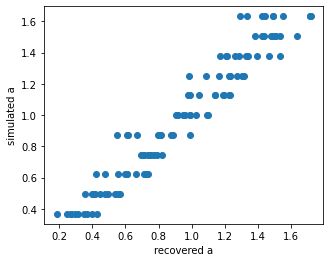

In [20]:
#load from file and examine recovery
m_reg = hddm.load('a_bwsubs_model_t200')
data_group = pd.read_csv('data_group.csv')

#look at correlation of recovered parameter with original
subjdf = data_group.groupby('subj_idx').first().reset_index()

## check for residual correlation with x 
a_int_recovered =[]

#obtain mean a intercept parameter for subjects
from scipy import stats
for i in range(0,(1+max(x_range))*subjs_per_bin):
    a='a_Intercept_subj.'
    a+=str(i)
    a+='.0'
    p1=m_reg.nodes_db.node[a] 
    a_int_recovered.append(p1.trace().mean())
    
#obtain mean a regression weight for z_x
a_x_recovered = m_reg.nodes_db.node['a_z_x'].trace().mean()

#compute predicted a parameter as a function of subject intercept and between-subjects regressor
subjdf.apred = a_int_recovered + a_x_recovered * subjdf.z_x

#correlation of recovered a with population a. r = .97 here: good!
fig = plt.figure()
fig.set_size_inches(5, 4)
plt.scatter(subjdf.apred,subjdf.a_population) #predicted versus observed a
plt.xlabel('recovered a')
plt.ylabel('simulated a')
plt.savefig('correlation of simulated and recovered a params.png', dpi=300, format='png')
print('Pearson correlation between a_x and x') 
print(stats.pearsonr(subjdf.apred,subjdf.a_population)) # correlation between predicted a value and population a value

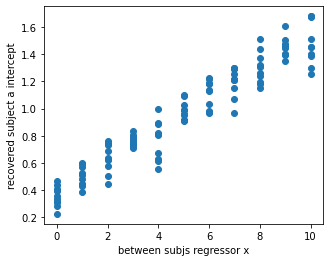

Pearson correlation between a_x and x
(0.9623671484978007, 6.184818852062877e-63)


<Figure size 432x288 with 0 Axes>

In [21]:
#correlation of subject intercept with between-subjects regressor
#should be zero correlation if entirely accounted for by x regressor - this correlation should instead be positive if x is removed from the model fit
fig = plt.figure()
fig.set_size_inches(5, 4)
plt.scatter(subjdf.x,a_int_recovered)
plt.xlabel('between subjs regressor x')
plt.ylabel('recovered subject a intercept')
plt.show()
plt.savefig('residual correlation between subj intercept and x.png', dpi=300, format='png')
print('Pearson correlation between a_x and x') 
print(stats.pearsonr(a_int_recovered,subjdf.x))